# PCA and Clusters of LendingClub

## Initial Checking/Cleaning

In [4]:
# Import all the necessary libraries
import pandas as pd
import numpy as np
import random

from scipy import stats
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

Load in the file

In [9]:
# Change the directory
%cd ""

# Read in the file and drop the duplicate index column
df = pd.read_csv("PMLendingClub.csv")
df = df.drop(["Unnamed: 0"], axis=1)

# Check the column/row count and see what the top of the table looks like
print(df.shape)
df.head(10)

Check missing value information for columns

In [7]:
# Set a variable for the count of missing values in each column (as an array)
missing = sum(df.isnull().values)

# Get a list of the column names
lc_columns = list(df)

# print the column names and the array
print(lc_columns)
print(missing)

# Create a new dataframe
df_missing = pd.DataFrame()

# Make columns in the dataframe of the original df's column names, and the number of missing values
df_missing["columns"] = lc_columns
df_missing["missing"] = missing
df_missing

['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'issue_d', 'loan_status', 'zip_code', 'addr_state', 'dti', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'last_pymnt_amnt', 'application_type', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'year']
[1722891       0       0       0       0       0       0  109684  103808
       0       0       0       0       1       0     579       1  854924
 1430370       0       0       0    1120       0       0       0       0
       0       0       0       0   27741   27741    7495   27771   25812
   26733   27894   26248   27741    

,columns,missing
0,id,1722891
1,loan_amnt,0
2,funded_amnt,0
3,term,0
4,int_rate,0
5,installment,0
6,grade,0
7,emp_title,109684
8,emp_length,103808
9,home_ownership,0


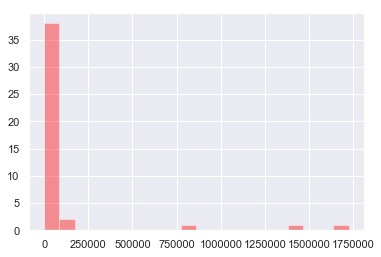

In [4]:
# Create a distribution of the columns by missing value count
fig = sns.distplot(missing, kde = False, bins = 20, color = "red");
plt.show(fig)

In [5]:
# Get the amount of columns in the orignal df from the length of the column name list
print(len(lc_columns))

# Keep columns where the missing value amount is less than 150000 (about 10% of the total length of the df)
columns_keep = list(df_missing[df_missing['missing'] < 150000]['columns'])
len(columns_keep)

43


40

Re-import data without the dropped columns

In [6]:
# Read in the data again, with only the columns from the previous step
df_lc = pd.read_csv("PMLendingClub.csv", sep=',', usecols=columns_keep)

# Print the column/row count
df_lc.shape

(1722891, 40)

In [7]:
# Get descriptive stats about each column (.T is used to transpose the columns into rows)
describe_df_lc = df_lc.describe(include='all').T
describe_df_lc

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
loan_amnt,1.72289e+06,NaN,NaN,NaN,14863.5,8901.05,1000,8000,12800,20000,40000
funded_amnt,1.72289e+06,NaN,NaN,NaN,14863.2,8900.85,1000,8000,12800,20000,40000
term,1722891,2,36 months,1233549,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,1722891,321,11.99%,49202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
installment,1.72289e+06,NaN,NaN,NaN,442.866,261.563,4.93,253.9,378.86,585.22,1719.83
grade,1722891,7,C,514463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_title,1613207,426790,Teacher,30145,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,1619083,11,10+ years,578254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,1722891,6,MORTGAGE,853271,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,1.72289e+06,NaN,NaN,NaN,77607,119539,0,46500,65000,92000,1.1e+08


Choosing Numeric Variables

In [8]:
# Create a list of columns (which are the rows in the descriptive stats table) where the unique 
# column in the descriptive stats is NaN (since this is where the data is continuous)
numeric_columns = describe_df_lc[describe_df_lc.loc[:,["unique"]].isna().any(axis=1)]

# Turn the column name list into an actual list
numeric_columns_list = list(numeric_columns.index)
print(len(numeric_columns_list))

# Subset the lendingcree dataframe for the columns that are continuous
df_lc_numeric = df_lc[numeric_columns_list]
print(df_lc_numeric.shape)
df_lc_numeric.head(50)

27
(1722891, 27)


,loan_amnt,funded_amnt,installment,annual_inc,dti,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,...,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,year
0,10000.0,10000.0,321.13,102000.0,15.55,0.0,9.0,0.0,9912.0,22.0,...,3.0,4349.0,973.0,89.4,77.3,66.7,58486.0,39143.0,9200.0,2013
1,20800.0,20800.0,706.16,81500.0,16.73,2.0,29.0,0.0,23473.0,41.0,...,9.0,869.0,6811.0,54.6,90.2,50.0,43100.0,23473.0,15000.0,2013
2,8000.0,8000.0,261.88,33000.0,15.75,1.0,9.0,1.0,7203.0,16.0,...,2.0,1772.0,2255.0,72.5,100.0,75.0,33226.0,15949.0,8200.0,2013
3,28000.0,28000.0,872.52,325000.0,18.55,1.0,15.0,0.0,29581.0,31.0,...,6.0,53306.0,13901.0,67.1,100.0,16.7,850886.0,199739.0,42200.0,2013
4,11500.0,11500.0,323.54,32760.0,27.06,0.0,12.0,0.0,9996.0,17.0,...,9.0,2060.0,2689.0,70.1,100.0,50.0,30891.0,24724.0,9000.0,2013
5,4800.0,4800.0,157.13,39600.0,2.49,2.0,3.0,0.0,4136.0,8.0,...,0.0,1379.0,21564.0,16.1,100.0,0.0,25700.0,4136.0,25700.0,2013
6,27050.0,27050.0,885.46,55000.0,22.87,0.0,14.0,0.0,36638.0,27.0,...,3.0,9570.0,16473.0,53.9,100.0,25.0,138554.0,70186.0,35700.0,2013
7,7550.0,7550.0,266.34,28000.0,8.40,0.0,4.0,0.0,5759.0,5.0,...,1.0,1440.0,160.0,96.0,100.0,100.0,8000.0,5759.0,4000.0,2013
8,12000.0,12000.0,368.45,105000.0,14.05,1.0,12.0,0.0,13168.0,22.0,...,4.0,26765.0,39432.0,25.0,95.5,0.0,333044.0,42603.0,52600.0,2013
9,12000.0,12000.0,398.52,130000.0,13.03,1.0,9.0,0.0,10805.0,19.0,...,4.0,36362.0,3567.0,93.0,100.0,1.0,365874.0,44327.0,10700.0,2013


## Trim out missing values

In [9]:
# Remove NA's
df_lc_numeric_NoNA = df_lc_numeric.dropna()

print(df_lc_numeric_NoNA.shape)

(1675043, 27)


Check to make sure no missing values remain

In [10]:
# Set a variable for the count of missing values in each column (as an array)
missing2 = sum(df_lc_numeric_NoNA.isnull().values)

# Get a list of the column names
lc_columns2 = list(df_lc_numeric_NoNA)

# print the column names and the array
print(lc_columns2)
print(missing2)

# Create a new dataframe
df_missing2 = pd.DataFrame()

# Make columns in the dataframe of the original df's column names, and the number of missing values
df_missing2["columns"] = lc_columns2
df_missing2["missing"] = missing2
df_missing2

['loan_amnt', 'funded_amnt', 'installment', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'last_pymnt_amnt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'year']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


,columns,missing
0,loan_amnt,0
1,funded_amnt,0
2,installment,0
3,annual_inc,0
4,dti,0
5,inq_last_6mths,0
6,open_acc,0
7,pub_rec,0
8,revol_bal,0
9,total_acc,0


## Outlier Analysis

In [8]:
# Create a fraction for the number of outliers to make
outlier_frac = 0.015

# Create a variable to use to run the specific outlier test Elliptic Envelope, and use 
# it on the dataframe
outlier_Ell = EllipticEnvelope(contamination=outlier_frac)
outlier_Ell.fit(df_lc_numeric_NoNA)

# Run predictions on the dataset to get a tag of -1 for outliers, then get the count of 
# outliers (this creates an ndarray of values)
pred = outlier_Ell.predict(df_lc_numeric_NoNA)
print(sum(pred == -1))

Add outlier tags to data frame

In [12]:
# Get the column names
col_names = list(df_lc_numeric_NoNA.columns)
col_names

# Get the row length of the dataframe without missing values
print(df_lc_numeric_NoNA.shape)

# Create a variable equal to the amount of rows in the dataframe
x = df_lc_numeric_NoNA.shape
y = x[0]
y

# Use length in the np reshaping to assign the prediction tag to the dataframe
df_lc_numeric_NoNA_Out = np.hstack((df_lc_numeric_NoNA, pred.reshape(y,1)))
print(df_lc_numeric_NoNA_Out.shape)

# Turn the outliers array into a dataframe (using colnames with the index of the actual data 
# dataframe with the NAs removed)
df_lc_numeric_NoNA_OutTagged = pd.DataFrame(df_lc_numeric_NoNA_Out, columns = col_names + ["outliers"],
                                  index  =  df_lc_numeric_NoNA.index)

print(df_lc_numeric_NoNA_OutTagged.shape)

# Add the outliers to the main dataset
df2 = pd.concat([df,  df_lc_numeric_NoNA_OutTagged['outliers']], axis = 1)
df2

(1675043, 27)
(1675043, 28)
(1675043, 28)


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,...,avg_cur_bal,bc_open_to_buy,bc_util,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,year,outliers
0,NaN,10000.0,10000.0,36 months,9.67%,321.13,B,Registered Nurse,7 years,MORTGAGE,...,4349.0,973.0,89.4,77.3,66.7,58486.0,39143.0,9200.0,2013,1.0
1,NaN,20800.0,20800.0,36 months,13.53%,706.16,B,Operations Manager,10+ years,RENT,...,869.0,6811.0,54.6,90.2,50.0,43100.0,23473.0,15000.0,2013,1.0
2,NaN,8000.0,8000.0,36 months,10.99%,261.88,B,PARTS MANAGER,2 years,MORTGAGE,...,1772.0,2255.0,72.5,100.0,75.0,33226.0,15949.0,8200.0,2013,1.0
3,NaN,28000.0,28000.0,36 months,7.62%,872.52,A,Area Sales Manager,5 years,MORTGAGE,...,53306.0,13901.0,67.1,100.0,16.7,850886.0,199739.0,42200.0,2013,1.0
4,NaN,11500.0,11500.0,60 months,22.90%,323.54,E,Secretary,4 years,RENT,...,2060.0,2689.0,70.1,100.0,50.0,30891.0,24724.0,9000.0,2013,1.0
5,NaN,4800.0,4800.0,36 months,10.99%,157.13,B,Surgical Technician,2 years,MORTGAGE,...,1379.0,21564.0,16.1,100.0,0.0,25700.0,4136.0,25700.0,2013,1.0
6,NaN,27050.0,27050.0,36 months,10.99%,885.46,B,Team Leadern Customer Ops & Systems,10+ years,OWN,...,9570.0,16473.0,53.9,100.0,25.0,138554.0,70186.0,35700.0,2013,1.0
7,NaN,7550.0,7550.0,36 months,16.24%,266.34,C,Special Order Fulfillment Clerk,3 years,RENT,...,1440.0,160.0,96.0,100.0,100.0,8000.0,5759.0,4000.0,2013,1.0
8,NaN,12000.0,12000.0,36 months,6.62%,368.45,A,MANAGER INFORMATION DELIVERY,10+ years,MORTGAGE,...,26765.0,39432.0,25.0,95.5,0.0,333044.0,42603.0,52600.0,2013,1.0
9,NaN,12000.0,12000.0,36 months,11.99%,398.52,B,LTC,10+ years,MORTGAGE,...,36362.0,3567.0,93.0,100.0,1.0,365874.0,44327.0,10700.0,2013,1.0


## Standardize the data

Drop outliers

In [13]:
# Drop the outliers
df_lc_numeric_NoNA_OutTagged_2 = df_lc_numeric_NoNA_OutTagged[df_lc_numeric_NoNA_OutTagged['outliers'] == 1]
df_lc_numeric_NoNA_OutTagged_2.shape
df_lc_numeric_NoNA_OutTagged_2

,loan_amnt,funded_amnt,installment,annual_inc,dti,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,...,avg_cur_bal,bc_open_to_buy,bc_util,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,year,outliers
0,10000.0,10000.0,321.13,102000.0,15.55,0.0,9.0,0.0,9912.0,22.0,...,4349.0,973.0,89.4,77.3,66.7,58486.0,39143.0,9200.0,2013.0,1.0
1,20800.0,20800.0,706.16,81500.0,16.73,2.0,29.0,0.0,23473.0,41.0,...,869.0,6811.0,54.6,90.2,50.0,43100.0,23473.0,15000.0,2013.0,1.0
2,8000.0,8000.0,261.88,33000.0,15.75,1.0,9.0,1.0,7203.0,16.0,...,1772.0,2255.0,72.5,100.0,75.0,33226.0,15949.0,8200.0,2013.0,1.0
3,28000.0,28000.0,872.52,325000.0,18.55,1.0,15.0,0.0,29581.0,31.0,...,53306.0,13901.0,67.1,100.0,16.7,850886.0,199739.0,42200.0,2013.0,1.0
4,11500.0,11500.0,323.54,32760.0,27.06,0.0,12.0,0.0,9996.0,17.0,...,2060.0,2689.0,70.1,100.0,50.0,30891.0,24724.0,9000.0,2013.0,1.0
5,4800.0,4800.0,157.13,39600.0,2.49,2.0,3.0,0.0,4136.0,8.0,...,1379.0,21564.0,16.1,100.0,0.0,25700.0,4136.0,25700.0,2013.0,1.0
6,27050.0,27050.0,885.46,55000.0,22.87,0.0,14.0,0.0,36638.0,27.0,...,9570.0,16473.0,53.9,100.0,25.0,138554.0,70186.0,35700.0,2013.0,1.0
7,7550.0,7550.0,266.34,28000.0,8.40,0.0,4.0,0.0,5759.0,5.0,...,1440.0,160.0,96.0,100.0,100.0,8000.0,5759.0,4000.0,2013.0,1.0
8,12000.0,12000.0,368.45,105000.0,14.05,1.0,12.0,0.0,13168.0,22.0,...,26765.0,39432.0,25.0,95.5,0.0,333044.0,42603.0,52600.0,2013.0,1.0
9,12000.0,12000.0,398.52,130000.0,13.03,1.0,9.0,0.0,10805.0,19.0,...,36362.0,3567.0,93.0,100.0,1.0,365874.0,44327.0,10700.0,2013.0,1.0


In [14]:
# Create a dataframe without the year and outlier columns
df_lc_numeric_NoNA_OutTagged_2 = df_lc_numeric_NoNA_OutTagged_2.drop(columns=["year", "outliers"])
print(df_lc_numeric_NoNA_OutTagged_2.shape)

# Create the scaler
scaler = StandardScaler()

# transform the dataframe so it is standardized -> returns a ndarray
df_lc_numeric_NoNA_OutTagged_std = scaler.fit_transform(df_lc_numeric_NoNA_OutTagged_2)
print(df_lc_numeric_NoNA_OutTagged_std.shape)
df_lc_numeric_NoNA_OutTagged_std

(1649917, 26)
(1649917, 26)


array([[-0.54506827, -0.54506826, -0.46250414, ..., -0.69106074,
        -0.235226  , -0.61175272],
       [ 0.67585556,  0.67585559,  1.02126505, ..., -0.78519188,
        -0.58520189, -0.3365046 ],
       [-0.77116527, -0.77116527, -0.69083265, ..., -0.84560076,
        -0.75324392, -0.65920929],
       ...,
       [-0.54506827, -0.54506826, -0.42022965, ...,  0.19562331,
        -0.29541649, -0.95344004],
       [ 0.19539942,  0.19539945,  0.04159125, ..., -0.73869528,
        -0.53412372, -0.12295002],
       [-0.31897126, -0.31897125, -0.43722423, ..., -0.32099063,
         0.34758325, -0.00430859]])

## Run the PCA

In [15]:
# Set the amount of variation to be explained
pca_Var = PCA(0.90)

# Fit the PCA to the dataframe
pca_Var.fit(df_lc_numeric_NoNA_OutTagged_std)

# Check how many components will be made
print(pca_Var.n_components_)

# Create the components (this will create an ndarray)
pca_components = pca_Var.transform(df_lc_numeric_NoNA_OutTagged_std)

print(pca_components.shape)
pca_components.view()

12
(1649917, 12)


array([[-1.83006843, -1.06275671,  0.55970494, ...,  0.24475463,
        -0.15189305,  0.06259372],
       [ 1.82735544,  0.22953567, -1.45223462, ...,  0.81189438,
        -0.13424411, -0.71261961],
       [-2.99282082, -0.65758341, -0.08106974, ...,  0.60296193,
         0.44175584,  0.0437871 ],
       ...,
       [-1.90287207, -1.36751779,  2.0995016 , ...,  0.01160501,
        -0.82320401, -0.46915461],
       [-0.43943669,  0.4295239 , -1.37650393, ..., -0.87782914,
        -0.54346   , -0.18162606],
       [-1.16269737,  1.34882063, -0.96373401, ..., -1.2960571 ,
         0.93777014,  0.95096905]])

Check column affect on PCs

<Figure size 1440x720 with 0 Axes>

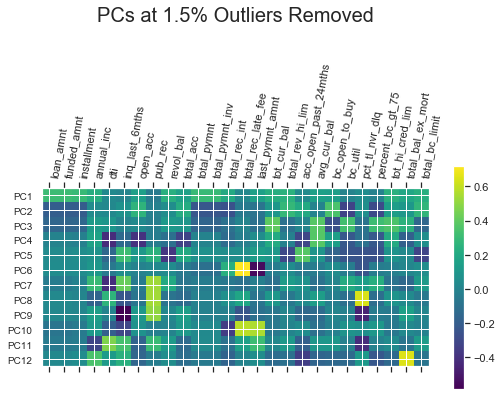

<Figure size 1440x720 with 0 Axes>

In [16]:
# Get a list of all the PC columns
feature_names = list(df_lc_numeric_NoNA_OutTagged_2.columns)

# Create a heatmap of the PCs compared to the original columns
plt.matshow(pca_Var.components_, cmap="viridis")
plt.yticks(range(12), ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10',
                         'PC11','PC12'], fontsize=10)
plt.xticks(range(len(feature_names)), feature_names, rotation=80, ha='left')
plt.title('PCs at 1.5% Outliers Removed',fontsize=20, y=1.9)
plt.colorbar()
plt.figure(figsize=(20,10))

Merge the PCs into the dataframe

In [17]:
# Create a blank list for the column names
pca_Cols = []

# Create a list of 12 PCx columns
for i in range(1,13):
    pca_Cols.append("PC"+str(i))
print(pca_Cols)

# Make the array of PC's into a dataframe, using the list of columns names as column names and the index
# of the dataframe with no NAs or outliers as the index
df_PCs = pd.DataFrame(pca_components, columns = pca_Cols, index  =  df_lc_numeric_NoNA_OutTagged_2.index)
print(df_PCs)

# Create a combined dataset of the dataframe and the PCs, lined up by index
df_w_PCs = pd.concat([df2,  df_PCs], axis = 1)
df_w_PCs

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12']
              PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0       -1.830068 -1.062757  0.559705  0.044143 -0.339974  0.501504  0.031464   
1        1.827355  0.229536 -1.452235 -2.721638  1.773666 -0.828059  0.687506   
2       -2.992821 -0.657583 -0.081070 -0.309064 -0.496588  0.876136  1.221146   
3        7.882377  1.233621  4.109054  2.805488  1.961078 -1.738943  0.249205   
4       -1.031967 -1.191477 -0.871659 -1.593020  0.090658 -0.424906 -0.815519   
5       -3.308395  1.118995 -2.094352  2.330378 -0.358512 -0.081272  0.894133   
6        3.369309 -0.877816 -1.841686 -0.518087 -1.058611 -0.303804 -0.691441   
7       -3.359323 -2.233086  0.015663  0.579969 -1.710099 -0.202126  0.636296   
8        0.963791  2.814465 -0.359994  2.105470 -0.294124  0.366645  0.032526   
9        0.136255 -0.110402  1.886406  1.822262  0.665514 -0.042086  0.181384   
10      -1.259543  1.

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,...,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,NaN,10000.0,10000.0,36 months,9.67%,321.13,B,Registered Nurse,7 years,MORTGAGE,...,0.559705,0.044143,-0.339974,0.501504,0.031464,-1.715910,1.262993,0.244755,-0.151893,0.062594
1,NaN,20800.0,20800.0,36 months,13.53%,706.16,B,Operations Manager,10+ years,RENT,...,-1.452235,-2.721638,1.773666,-0.828059,0.687506,-1.695199,-0.535712,0.811894,-0.134244,-0.712620
2,NaN,8000.0,8000.0,36 months,10.99%,261.88,B,PARTS MANAGER,2 years,MORTGAGE,...,-0.081070,-0.309064,-0.496588,0.876136,1.221146,1.019537,-0.335233,0.602962,0.441756,0.043787
3,NaN,28000.0,28000.0,36 months,7.62%,872.52,A,Area Sales Manager,5 years,MORTGAGE,...,4.109054,2.805488,1.961078,-1.738943,0.249205,0.192669,-0.332845,1.559021,-0.496424,2.666160
4,NaN,11500.0,11500.0,60 months,22.90%,323.54,E,Secretary,4 years,RENT,...,-0.871659,-1.593020,0.090658,-0.424906,-0.815519,0.723661,-0.502176,-0.267787,-0.488054,-0.971549
5,NaN,4800.0,4800.0,36 months,10.99%,157.13,B,Surgical Technician,2 years,MORTGAGE,...,-2.094352,2.330378,-0.358512,-0.081272,0.894133,-0.350508,-1.580957,-0.326201,0.318634,1.032165
6,NaN,27050.0,27050.0,36 months,10.99%,885.46,B,Team Leadern Customer Ops & Systems,10+ years,OWN,...,-1.841686,-0.518087,-1.058611,-0.303804,-0.691441,0.368214,0.225052,-0.200283,0.065192,0.206763
7,NaN,7550.0,7550.0,36 months,16.24%,266.34,C,Special Order Fulfillment Clerk,3 years,RENT,...,0.015663,0.579969,-1.710099,-0.202126,0.636296,0.009039,-0.468348,0.237794,-0.746157,-0.364595
8,NaN,12000.0,12000.0,36 months,6.62%,368.45,A,MANAGER INFORMATION DELIVERY,10+ years,MORTGAGE,...,-0.359994,2.105470,-0.294124,0.366645,0.032526,-0.040746,-0.484181,-0.638085,0.165033,-0.144397
9,NaN,12000.0,12000.0,36 months,11.99%,398.52,B,LTC,10+ years,MORTGAGE,...,1.886406,1.822262,0.665514,-0.042086,0.181384,0.449580,-0.943022,-0.578562,-0.847659,0.297731


Add an NA column

In [18]:
df_w_PCs["NAs"] = df_w_PCs["PC1"].isna()
print(df_w_PCs.columns)
df_w_PCs

Index(['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'issue_d', 'loan_status', 'zip_code', 'addr_state', 'dti',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_int', 'total_rec_late_fee', 'last_pymnt_amnt',
       'application_type', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit', 'year', 'outliers', 'PC1', 'PC2',
       'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12',
       'NAs'],
      dtype='object')


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,...,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,NAs
0,NaN,10000.0,10000.0,36 months,9.67%,321.13,B,Registered Nurse,7 years,MORTGAGE,...,0.044143,-0.339974,0.501504,0.031464,-1.715910,1.262993,0.244755,-0.151893,0.062594,False
1,NaN,20800.0,20800.0,36 months,13.53%,706.16,B,Operations Manager,10+ years,RENT,...,-2.721638,1.773666,-0.828059,0.687506,-1.695199,-0.535712,0.811894,-0.134244,-0.712620,False
2,NaN,8000.0,8000.0,36 months,10.99%,261.88,B,PARTS MANAGER,2 years,MORTGAGE,...,-0.309064,-0.496588,0.876136,1.221146,1.019537,-0.335233,0.602962,0.441756,0.043787,False
3,NaN,28000.0,28000.0,36 months,7.62%,872.52,A,Area Sales Manager,5 years,MORTGAGE,...,2.805488,1.961078,-1.738943,0.249205,0.192669,-0.332845,1.559021,-0.496424,2.666160,False
4,NaN,11500.0,11500.0,60 months,22.90%,323.54,E,Secretary,4 years,RENT,...,-1.593020,0.090658,-0.424906,-0.815519,0.723661,-0.502176,-0.267787,-0.488054,-0.971549,False
5,NaN,4800.0,4800.0,36 months,10.99%,157.13,B,Surgical Technician,2 years,MORTGAGE,...,2.330378,-0.358512,-0.081272,0.894133,-0.350508,-1.580957,-0.326201,0.318634,1.032165,False
6,NaN,27050.0,27050.0,36 months,10.99%,885.46,B,Team Leadern Customer Ops & Systems,10+ years,OWN,...,-0.518087,-1.058611,-0.303804,-0.691441,0.368214,0.225052,-0.200283,0.065192,0.206763,False
7,NaN,7550.0,7550.0,36 months,16.24%,266.34,C,Special Order Fulfillment Clerk,3 years,RENT,...,0.579969,-1.710099,-0.202126,0.636296,0.009039,-0.468348,0.237794,-0.746157,-0.364595,False
8,NaN,12000.0,12000.0,36 months,6.62%,368.45,A,MANAGER INFORMATION DELIVERY,10+ years,MORTGAGE,...,2.105470,-0.294124,0.366645,0.032526,-0.040746,-0.484181,-0.638085,0.165033,-0.144397,False
9,NaN,12000.0,12000.0,36 months,11.99%,398.52,B,LTC,10+ years,MORTGAGE,...,1.822262,0.665514,-0.042086,0.181384,0.449580,-0.943022,-0.578562,-0.847659,0.297731,False


In [19]:
# Check a sample of the dataframe
df_w_PCs.sample(100)

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,...,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,NAs
198153,NaN,12000.0,12000.0,36 months,6.49%,367.74,A,Software QA Analyst,3 years,RENT,...,-0.354761,-1.100666,-0.060296,-0.931316,0.294891,0.527871,0.020825,-0.288485,0.683538,False
720517,NaN,6000.0,6000.0,36 months,12.69%,201.27,C,electro-plating,8 years,RENT,...,-1.151680,0.843066,-0.103557,0.585156,-0.025765,-2.341076,-1.103392,0.662759,0.486421,False
323802,NaN,18000.0,18000.0,60 months,15.61%,434.01,D,Truck Driver,1 year,OWN,...,-0.515909,-0.874198,-0.316622,-0.466592,-0.196992,0.219051,-0.020849,-0.125539,-0.343380,False
1117338,NaN,33600.0,33600.0,60 months,14.49%,790.38,C,Sales,1 year,MORTGAGE,...,2.145019,1.211218,0.141207,-1.029627,1.358448,-1.968163,3.140178,0.951822,-1.321062,False
1383328,NaN,8000.0,8000.0,36 months,9.93%,257.88,B,certified nurses aide,5 years,MORTGAGE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
659479,NaN,14000.0,14000.0,36 months,15.61%,489.51,D,Manager,5 years,RENT,...,-1.779552,0.203948,-0.397495,-0.355405,-1.183704,0.079563,0.202191,1.355487,-0.334324,False
1246332,NaN,19200.0,19200.0,36 months,8.24%,603.79,B,Attorney,8 years,MORTGAGE,...,-1.226874,-0.004818,-0.609095,-0.438410,-1.438327,1.274598,1.277209,0.482594,-0.309751,False
1251334,NaN,6000.0,6000.0,36 months,12.74%,201.42,C,Cocktail Server,1 year,RENT,...,-0.228811,-0.518889,-0.115675,0.270391,0.127959,-0.879198,-0.229576,-0.230241,0.304525,False
333568,NaN,4725.0,4725.0,60 months,17.57%,118.89,D,Accounting Clerk,4 years,RENT,...,-0.065659,-1.069761,-0.639028,1.130372,-0.376835,-1.161990,0.564723,-0.295135,-0.277909,False
1075081,NaN,30000.0,30000.0,36 months,6.97%,925.91,A,Associate Broker,10+ years,MORTGAGE,...,5.296829,2.147826,0.030396,-0.188255,1.165554,-1.361015,-1.451126,-1.079611,-1.385011,False


## Clustering

In [20]:
# Get a subset of the data where there are no outliers or missing values
df_w_PCs_2 = df_w_PCs[(df_w_PCs["outliers"]==1) & (df_w_PCs["NAs"]==False)]
print(df_w_PCs_2.shape)
df_w_PCs_2.sample(50)

(1649917, 57)


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,...,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,NAs
314651,NaN,10000.0,10000.0,36 months,15.61%,349.65,D,NaN,NaN,MORTGAGE,...,-2.738511,-1.496907,-0.328518,-0.255201,0.213339,0.051090,0.155011,-0.258435,-0.999518,False
202503,NaN,35000.0,35000.0,36 months,7.49%,1088.56,A,"Emergency Room Supervisor, RN",< 1 year,MORTGAGE,...,2.238203,-2.190428,-0.633930,-0.086466,0.202666,0.136040,0.389360,1.328043,-1.005956,False
1146117,NaN,3000.0,3000.0,36 months,18.99%,109.96,D,Bus Operator,3 years,RENT,...,-2.549022,0.791159,0.706503,0.900599,-0.530535,-1.417134,0.995002,-0.585822,0.020168,False
1081409,NaN,7000.0,7000.0,36 months,5.32%,210.81,A,Parts consultant,10+ years,MORTGAGE,...,1.189846,-3.409953,0.575637,0.727579,-0.216387,0.278729,0.027966,0.450917,-0.388366,False
107771,NaN,21000.0,21000.0,36 months,7.62%,654.39,A,OEConnection,< 1 year,MORTGAGE,...,1.046086,-0.502028,0.013456,0.393034,0.065317,-0.741146,-0.618277,-0.299089,0.296378,False
944231,NaN,21500.0,21500.0,36 months,11.99%,714.01,C,CEO,10+ years,RENT,...,0.728909,-1.147113,-0.624057,1.866829,0.490886,0.747592,0.993874,0.269449,0.327435,False
844228,NaN,14000.0,14000.0,36 months,10.49%,454.97,B,Remote Coding Data Reviewer,4 years,MORTGAGE,...,1.459018,-0.457777,0.120873,-0.193461,-0.071172,0.050069,-0.280793,-0.382521,-0.325849,False
419310,NaN,14500.0,14500.0,36 months,11.99%,481.54,B,Lead Project Manager,10+ years,MORTGAGE,...,-0.313674,-0.583090,-0.852028,-0.132196,0.028909,-0.026683,0.812391,-0.441818,-0.426083,False
11051,NaN,3600.0,3600.0,36 months,15.10%,124.98,C,Architect,10+ years,RENT,...,-1.564741,-1.935526,-0.206516,1.277475,-0.564224,-1.173548,-0.168565,0.901851,0.774447,False
128996,NaN,12000.0,12000.0,36 months,12.12%,399.26,B,Waste Managment,3 years,MORTGAGE,...,-0.291202,-0.629332,-1.250622,-0.635771,0.632877,-0.432089,0.772809,0.131112,0.102197,False


In [ ]:
# # Subset the PC columns only
# to_R_df = df_w_PCs_2[['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12']]

# # Save as a csv to import into R to check optimal clusters as a reference
# to_R_df.to_csv("clustersforR.csv")

In [21]:
# Create a blank list for the inertias of the clusters
Sum_of_squared_distances = []

# Look at clusters of 2-8 -> decided after several iterations
for i in range(2,9):
    # Specify the number of clusters
    k_Means = KMeans(n_clusters=i)
    # Fit the cluster size to the dataframe of PCs created before
    k_Means = k_Means.fit(df_w_PCs_2.loc[:,pca_Cols])
    # Create labels for each cluster
    df_w_PCs_2_labels = k_Means.labels_
    # Create the coordinates of the cluster centers
    centroids = k_Means.cluster_centers_
    # Add the inertia to the list
    Sum_of_squared_distances.append(k_Means.inertia_)
    # Print the number of clusters and the count of values in each cluster
    print(i, " Number of clusters")
    print(stats.itemfreq(df_w_PCs_2_labels))
    
    # Add the cluster labels as a column to the PCA dataset
    df_w_PCs_2[str(i) + " Clusters"] = df_w_PCs_2_labels

2  Number of clusters
[[      0 1135120]
 [      1  514797]]


C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3  Number of clusters
[[      0 1034731]
 [      1  398855]
 [      2  216331]]


C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


4  Number of clusters
[[     0 137927]
 [     1 420659]
 [     2 730520]
 [     3 360811]]


C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


5  Number of clusters
[[     0 441656]
 [     1 317314]
 [     2 304194]
 [     3 118564]
 [     4 468189]]


C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


6  Number of clusters
[[     0 156464]
 [     1 447283]
 [     2 101588]
 [     3 281280]
 [     4 398595]
 [     5 264707]]


C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7  Number of clusters
[[     0 368053]
 [     1 296389]
 [     2 143444]
 [     3  91127]
 [     4 377519]
 [     5 223235]
 [     6 150150]]


C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


8  Number of clusters
[[     0 147086]
 [     1 375748]
 [     2  90273]
 [     3 366382]
 [     4 293726]
 [     5 142813]
 [     6 221867]
 [     7  12022]]


C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
df_w_PCs_2

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,...,PC11,PC12,NAs,2 Clusters,3 Clusters,4 Clusters,5 Clusters,6 Clusters,7 Clusters,8 Clusters
0,NaN,10000.0,10000.0,36 months,9.67%,321.13,B,Registered Nurse,7 years,MORTGAGE,...,-0.151893,0.062594,False,0,0,2,4,1,4,1
1,NaN,20800.0,20800.0,36 months,13.53%,706.16,B,Operations Manager,10+ years,RENT,...,-0.134244,-0.712620,False,1,1,3,2,5,5,6
2,NaN,8000.0,8000.0,36 months,10.99%,261.88,B,PARTS MANAGER,2 years,MORTGAGE,...,0.441756,0.043787,False,0,0,2,4,1,4,1
3,NaN,28000.0,28000.0,36 months,7.62%,872.52,A,Area Sales Manager,5 years,MORTGAGE,...,-0.496424,2.666160,False,1,2,0,3,2,6,0
4,NaN,11500.0,11500.0,60 months,22.90%,323.54,E,Secretary,4 years,RENT,...,-0.488054,-0.971549,False,0,0,2,4,1,1,4
5,NaN,4800.0,4800.0,36 months,10.99%,157.13,B,Surgical Technician,2 years,MORTGAGE,...,0.318634,1.032165,False,0,0,2,0,4,0,3
6,NaN,27050.0,27050.0,36 months,10.99%,885.46,B,Team Leadern Customer Ops & Systems,10+ years,OWN,...,0.065192,0.206763,False,1,1,3,1,3,6,0
7,NaN,7550.0,7550.0,36 months,16.24%,266.34,C,Special Order Fulfillment Clerk,3 years,RENT,...,-0.746157,-0.364595,False,0,0,2,4,1,4,1
8,NaN,12000.0,12000.0,36 months,6.62%,368.45,A,MANAGER INFORMATION DELIVERY,10+ years,MORTGAGE,...,0.165033,-0.144397,False,0,2,1,2,5,2,5
9,NaN,12000.0,12000.0,36 months,11.99%,398.52,B,LTC,10+ years,MORTGAGE,...,-0.847659,0.297731,False,0,0,1,2,0,2,5


Check the elbow plot for the cluster amount to use

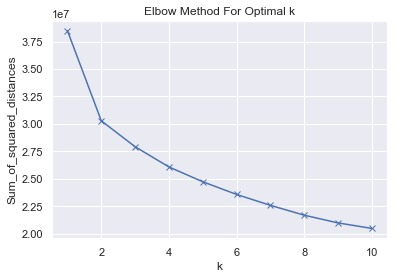

In [27]:
# Get the range used in the previous step
K = range(1, 11)

# Create a plot of the sum of squared distances (the inertia) of all the groups of clusters based on k
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Add the cluster labels to the main dataframe

In [23]:
df_final = pd.concat([df_w_PCs,  df_w_PCs_2[['2 Clusters', '3 Clusters', '4 Clusters', '5 Clusters', 
                                             '6 Clusters', '7 Clusters', '8 Clusters']]], axis = 1)
df_final.sample(100)

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,...,PC11,PC12,NAs,2 Clusters,3 Clusters,4 Clusters,5 Clusters,6 Clusters,7 Clusters,8 Clusters
675784,NaN,20000.0,20000.0,36 months,7.89%,625.72,A,Senior IS Analyst,1 year,MORTGAGE,...,0.330009,-0.017255,False,0.0,1.0,1.0,0.0,5.0,1.0,4.0
792760,NaN,25000.0,25000.0,36 months,6.68%,768.28,A,Senior Engineer,1 year,MORTGAGE,...,-0.658616,-0.902678,False,1.0,1.0,3.0,1.0,3.0,6.0,0.0
493081,NaN,29425.0,29425.0,60 months,17.86%,744.97,D,Office Manager,9 years,RENT,...,-0.914822,-0.486137,False,1.0,1.0,3.0,1.0,3.0,1.0,4.0
738505,NaN,18000.0,18000.0,36 months,13.99%,615.11,C,Office Manager,10+ years,MORTGAGE,...,-0.132648,-1.427816,False,1.0,1.0,1.0,2.0,5.0,5.0,6.0
1342782,NaN,10000.0,10000.0,36 months,11.44%,329.48,B,Compliance Analyst,7 years,RENT,...,2.341388,0.391233,False,0.0,0.0,2.0,0.0,4.0,0.0,3.0
517041,NaN,15000.0,15000.0,60 months,12.29%,335.87,C,Engineer,< 1 year,OWN,...,1.573103,0.421237,False,1.0,2.0,0.0,3.0,2.0,3.0,2.0
896704,NaN,5000.0,5000.0,36 months,9.75%,160.75,B,Residential Counselor,3 years,RENT,...,-0.339802,0.610440,False,0.0,0.0,2.0,0.0,4.0,0.0,3.0
1522067,NaN,4750.0,4750.0,36 months,14.08%,162.53,C,NaN,NaN,RENT,...,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1398747,NaN,20000.0,20000.0,36 months,5.32%,602.30,A,Police seargent,10+ years,MORTGAGE,...,-0.626740,0.453088,False,1.0,1.0,3.0,0.0,0.0,2.0,5.0
305228,NaN,12000.0,12000.0,60 months,16.99%,298.17,D,Sr. Warrant Officer,10+ years,RENT,...,-0.608433,0.491869,False,0.0,0.0,1.0,2.0,1.0,1.0,4.0


Export the final dataset to an csv

In [24]:
df_final.to_csv("PMLendingClub-WithClusters.csv")

## Examination of Clusters

In [3]:
# Read in the dataset with the clusters included, and drop the unnecessary index column
data = pd.read_csv("PMLendingClub-WithClusters.csv")
data = data.drop(["Unnamed: 0"], axis=1)
data

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,...,PC11,PC12,NAs,2 Clusters,3 Clusters,4 Clusters,5 Clusters,6 Clusters,7 Clusters,8 Clusters
0,NaN,10000.0,10000.0,36 months,9.67%,321.13,B,Registered Nurse,7 years,MORTGAGE,...,-0.151893,0.062594,False,0.0,0.0,2.0,4.0,1.0,4.0,1.0
1,NaN,20800.0,20800.0,36 months,13.53%,706.16,B,Operations Manager,10+ years,RENT,...,-0.134244,-0.712620,False,1.0,1.0,3.0,2.0,5.0,5.0,6.0
2,NaN,8000.0,8000.0,36 months,10.99%,261.88,B,PARTS MANAGER,2 years,MORTGAGE,...,0.441756,0.043787,False,0.0,0.0,2.0,4.0,1.0,4.0,1.0
3,NaN,28000.0,28000.0,36 months,7.62%,872.52,A,Area Sales Manager,5 years,MORTGAGE,...,-0.496424,2.666160,False,1.0,2.0,0.0,3.0,2.0,6.0,0.0
4,NaN,11500.0,11500.0,60 months,22.90%,323.54,E,Secretary,4 years,RENT,...,-0.488054,-0.971549,False,0.0,0.0,2.0,4.0,1.0,1.0,4.0
5,NaN,4800.0,4800.0,36 months,10.99%,157.13,B,Surgical Technician,2 years,MORTGAGE,...,0.318634,1.032165,False,0.0,0.0,2.0,0.0,4.0,0.0,3.0
6,NaN,27050.0,27050.0,36 months,10.99%,885.46,B,Team Leadern Customer Ops & Systems,10+ years,OWN,...,0.065192,0.206763,False,1.0,1.0,3.0,1.0,3.0,6.0,0.0
7,NaN,7550.0,7550.0,36 months,16.24%,266.34,C,Special Order Fulfillment Clerk,3 years,RENT,...,-0.746157,-0.364595,False,0.0,0.0,2.0,4.0,1.0,4.0,1.0
8,NaN,12000.0,12000.0,36 months,6.62%,368.45,A,MANAGER INFORMATION DELIVERY,10+ years,MORTGAGE,...,0.165033,-0.144397,False,0.0,2.0,1.0,2.0,5.0,2.0,5.0
9,NaN,12000.0,12000.0,36 months,11.99%,398.52,B,LTC,10+ years,MORTGAGE,...,-0.847659,0.297731,False,0.0,0.0,1.0,2.0,0.0,2.0,5.0


In [4]:
# Check the column names
list(data.columns)

['id',
 'loan_amnt',
 'funded_amnt',
 'term',
 'int_rate',
 'installment',
 'grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'issue_d',
 'loan_status',
 'zip_code',
 'addr_state',
 'dti',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int',
 'total_rec_late_fee',
 'last_pymnt_amnt',
 'application_type',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'year',
 'outliers',
 'PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PC10',
 'PC11',
 'PC12',
 'NAs',
 '2 Clusters',
 '3 Clusters',
 '4 Clusters',
 '5 Clusters',
 '6 Clusters',
 '7 Clusters',
 '8 Clusters']

Create Year marker for the 2 groups

In [4]:
dict_group = {
    '2012' : '2012-2014',
    '2013' : '2012-2014',
    '2014' : '2012-2014',
    '2015' : '2015-2017',
    '2016' : '2015-2017',
    '2017' : '2015-2017'
}

data['year'] = data['year'].astype(str)
data['Year Category'] = data["year"].map(dict_group)
data

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,...,PC12,NAs,2 Clusters,3 Clusters,4 Clusters,5 Clusters,6 Clusters,7 Clusters,8 Clusters,Year Category
0,NaN,10000.0,10000.0,36 months,9.67%,321.13,B,Registered Nurse,7 years,MORTGAGE,...,0.062594,False,0.0,0.0,2.0,4.0,1.0,4.0,1.0,2012-2014
1,NaN,20800.0,20800.0,36 months,13.53%,706.16,B,Operations Manager,10+ years,RENT,...,-0.712620,False,1.0,1.0,3.0,2.0,5.0,5.0,6.0,2012-2014
2,NaN,8000.0,8000.0,36 months,10.99%,261.88,B,PARTS MANAGER,2 years,MORTGAGE,...,0.043787,False,0.0,0.0,2.0,4.0,1.0,4.0,1.0,2012-2014
3,NaN,28000.0,28000.0,36 months,7.62%,872.52,A,Area Sales Manager,5 years,MORTGAGE,...,2.666160,False,1.0,2.0,0.0,3.0,2.0,6.0,0.0,2012-2014
4,NaN,11500.0,11500.0,60 months,22.90%,323.54,E,Secretary,4 years,RENT,...,-0.971549,False,0.0,0.0,2.0,4.0,1.0,1.0,4.0,2012-2014
5,NaN,4800.0,4800.0,36 months,10.99%,157.13,B,Surgical Technician,2 years,MORTGAGE,...,1.032165,False,0.0,0.0,2.0,0.0,4.0,0.0,3.0,2012-2014
6,NaN,27050.0,27050.0,36 months,10.99%,885.46,B,Team Leadern Customer Ops & Systems,10+ years,OWN,...,0.206763,False,1.0,1.0,3.0,1.0,3.0,6.0,0.0,2012-2014
7,NaN,7550.0,7550.0,36 months,16.24%,266.34,C,Special Order Fulfillment Clerk,3 years,RENT,...,-0.364595,False,0.0,0.0,2.0,4.0,1.0,4.0,1.0,2012-2014
8,NaN,12000.0,12000.0,36 months,6.62%,368.45,A,MANAGER INFORMATION DELIVERY,10+ years,MORTGAGE,...,-0.144397,False,0.0,2.0,1.0,2.0,5.0,2.0,5.0,2012-2014
9,NaN,12000.0,12000.0,36 months,11.99%,398.52,B,LTC,10+ years,MORTGAGE,...,0.297731,False,0.0,0.0,1.0,2.0,0.0,2.0,5.0,2012-2014


Subset the data

In [5]:
# Get a subset of the data where there are no outliers or missing values
data_2 = data[(data["outliers"]==1) & (data["NAs"]==False)]
print(data_2.shape)
data_2.sample(50)

(1649917, 65)


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,...,PC12,NAs,2 Clusters,3 Clusters,4 Clusters,5 Clusters,6 Clusters,7 Clusters,8 Clusters,Year Category
84983,NaN,9000.0,9000.0,36 months,15.31%,313.36,C,Menden Hall Inn,10+ years,MORTGAGE,...,0.437009,False,0.0,0.0,2.0,4.0,1.0,4.0,1.0,2012-2014
1348053,NaN,6000.0,6000.0,36 months,11.44%,197.69,B,specialty team member,2 years,RENT,...,1.231537,False,0.0,0.0,2.0,4.0,4.0,4.0,1.0,2015-2017
447040,NaN,8825.0,8825.0,36 months,11.99%,293.08,C,Director,6 years,MORTGAGE,...,0.006660,False,0.0,0.0,1.0,0.0,4.0,0.0,3.0,2015-2017
1174866,NaN,8000.0,8000.0,36 months,11.49%,263.78,B,Correction officer,6 years,RENT,...,0.158834,False,0.0,0.0,2.0,4.0,1.0,4.0,1.0,2015-2017
1040704,NaN,32000.0,32000.0,60 months,13.67%,739.13,C,Registered nurse,10+ years,OWN,...,0.081701,False,1.0,1.0,3.0,1.0,3.0,6.0,0.0,2015-2017
1700772,NaN,18775.0,18775.0,60 months,26.30%,565.48,E,Agency Development Manager,10+ years,MORTGAGE,...,-0.037813,False,1.0,1.0,3.0,1.0,0.0,1.0,4.0,2015-2017
1109917,NaN,5000.0,5000.0,36 months,13.49%,169.66,C,Facilities Director,2 years,OWN,...,-0.364330,False,0.0,0.0,2.0,4.0,1.0,4.0,1.0,2015-2017
1393524,NaN,2800.0,2800.0,36 months,10.91%,91.55,B,receiving unloader,10+ years,OWN,...,-0.217633,False,0.0,0.0,2.0,4.0,1.0,4.0,1.0,2015-2017
457921,NaN,15300.0,15300.0,60 months,20.99%,413.84,E,Spotter,8 years,RENT,...,-0.138092,False,0.0,0.0,2.0,4.0,1.0,4.0,1.0,2015-2017
1391244,NaN,12000.0,12000.0,60 months,14.08%,279.72,C,Service Director,10+ years,MORTGAGE,...,-1.421771,False,0.0,2.0,1.0,2.0,5.0,5.0,6.0,2015-2017


Scatter plots of clusters and first two PCs

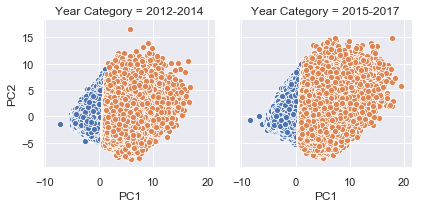

In [9]:
#Create a scatter plot of the clusters based on the first two PCs
x = sns.FacetGrid(data_2, col='Year Category', hue = "2 Clusters")
x.map(sns.scatterplot, "PC1", "PC2", legend='full', palette='rainbow')

# # Create a scatter plot of the clusters based on the first two PCs
# sns.scatterplot(x="PC1", y="PC2", data=data_2, legend='full', palette='rainbow', hue='2 Clusters')

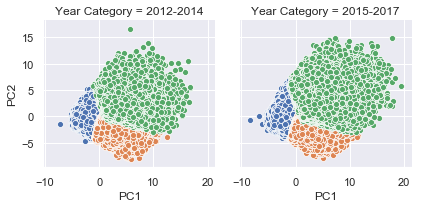

In [10]:
#Create a scatter plot of the clusters based on the first two PCs
x = sns.FacetGrid(data_2, col='Year Category', hue = "3 Clusters")
x.map(sns.scatterplot, "PC1", "PC2", legend='full', palette='rainbow')

# # Create a scatter plot of the clusters based on the first two PCs
# sns.scatterplot(x="PC1", y="PC2", data=data_2, legend='full', palette='rainbow', hue='3 Clusters')

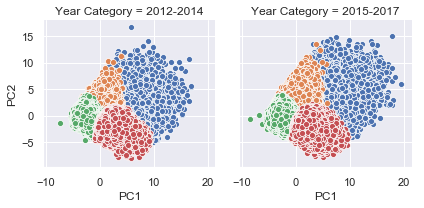

In [11]:
#Create a scatter plot of the clusters based on the first two PCs
x = sns.FacetGrid(data_2, col='Year Category', hue = "4 Clusters")
x.map(sns.scatterplot, "PC1", "PC2", legend='full', palette='rainbow')

# # Create a scatter plot of the clusters based on the first two PCs
# sns.scatterplot(x="PC1", y="PC2", data=data_2, legend='full', palette = 'rainbow', hue='4 Clusters')

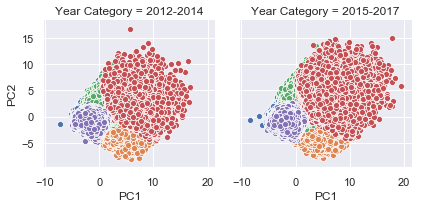

In [12]:
#Create a scatter plot of the clusters based on the first two PCs
x = sns.FacetGrid(data_2, col='Year Category', hue = "5 Clusters")
x.map(sns.scatterplot, "PC1", "PC2", legend='full', palette='rainbow')

# # Create a scatter plot of the clusters based on the first two PCs
# sns.scatterplot(x="PC1", y="PC2", data=data_2, legend='full', palette = 'rainbow',hue='5 Clusters')

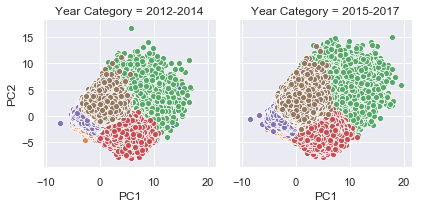

In [9]:
# Create a scatter plot of the clusters based on the first two PCs
x = sns.FacetGrid(data_2, col='Year Category', hue = "6 Clusters")
x.map(sns.scatterplot, "PC1", "PC2", legend='full', palette='rainbow')

# # Create a scatter plot of the clusters based on the first two PCs
# sns.scatterplot(x="PC1", y="PC2", data=data_2, legend='full', palette = 'rainbow',hue='6 Clusters')

# x.savefig("clusters.png")

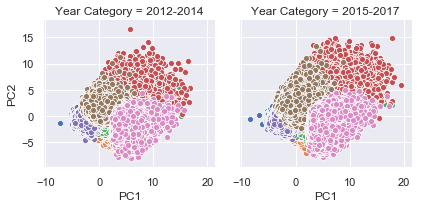

In [14]:
#Create a scatter plot of the clusters based on the first two PCs
x = sns.FacetGrid(data_2, col='Year Category', hue = "7 Clusters")
x.map(sns.scatterplot, "PC1", "PC2", legend='full', palette='rainbow')

# # Create a scatter plot of the clusters based on the first two PCs
# sns.scatterplot(x="PC1", y="PC2", data=data_2, legend='full', palette = 'rainbow',hue='7 Clusters')

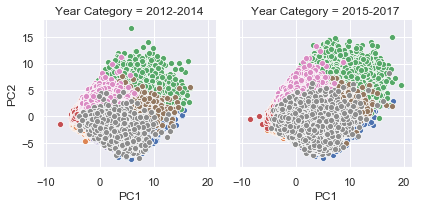

In [15]:
#Create a scatter plot of the clusters based on the first two PCs
x = sns.FacetGrid(data_2, col='Year Category', hue = "8 Clusters")
x.map(sns.scatterplot, "PC1", "PC2", legend='full', palette='rainbow')

# # Create a scatter plot of the clusters based on the first two PCs
# sns.scatterplot(x="PC1", y="PC2", data=data_2, legend='full', palette = 'rainbow',hue='8 Clusters')

Split the dataframe

In [6]:
# Split the dataframe into two parts (2012-2014, and 2015-2017)
data_1214 = data_2[data_2["year"] <= '2014']
data_1517 = data_2[data_2["year"] >= '2015']

# Print the dataframes and check the rows counts
print(data_1214)
print("***********************************************************************************************")
print(data_1517)

print(data_1214.shape)
print(data_1517.shape)

        id  loan_amnt  funded_amnt        term int_rate  installment grade  \
0      NaN    10000.0      10000.0   36 months    9.67%       321.13     B   
1      NaN    20800.0      20800.0   36 months   13.53%       706.16     B   
2      NaN     8000.0       8000.0   36 months   10.99%       261.88     B   
3      NaN    28000.0      28000.0   36 months    7.62%       872.52     A   
4      NaN    11500.0      11500.0   60 months   22.90%       323.54     E   
5      NaN     4800.0       4800.0   36 months   10.99%       157.13     B   
6      NaN    27050.0      27050.0   36 months   10.99%       885.46     B   
7      NaN     7550.0       7550.0   36 months   16.24%       266.34     C   
8      NaN    12000.0      12000.0   36 months    6.62%       368.45     A   
9      NaN    12000.0      12000.0   36 months   11.99%       398.52     B   
10     NaN    12000.0      12000.0   36 months   10.99%       392.81     B   
11     NaN    24000.0      24000.0   36 months   13.53%       81

         id  loan_amnt  funded_amnt        term int_rate  installment grade  \
423810  NaN    24700.0      24700.0   36 months   11.99%       820.28     C   
423811  NaN    10000.0      10000.0   36 months   12.88%       336.37     C   
423812  NaN    20000.0      20000.0   36 months    6.49%       612.89     A   
423813  NaN    20000.0      20000.0   36 months    5.32%       602.30     A   
423814  NaN    18000.0      18000.0   36 months    7.49%       559.83     A   
423815  NaN    17475.0      17475.0   36 months   13.99%       597.17     C   
423816  NaN    16000.0      16000.0   60 months   12.88%       363.07     C   
423817  NaN    23850.0      23850.0   60 months   17.27%       596.21     D   
423818  NaN    35000.0      35000.0   60 months   12.88%       794.21     C   
423819  NaN    16250.0      16250.0   60 months   13.44%       373.41     C   
423820  NaN    15000.0      15000.0   60 months   10.78%       324.50     B   
423821  NaN     7200.0       7200.0   36 months   17

Get the percentage of loan grades for each year group

In [12]:
# Create the length of dataframes for each yeare group
a = len(data_1214['grade'])
b = len(data_1517['grade'])

# Create a list of grades
grade_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

# For the 2012-2014 group, print the length of each grade / length of the whole dataframe * 100 (to print
# the percent of each grade)
print("Years: 2012-2014")
for i in grade_list:
    per = (len(data_1214[data_1214['grade'] == i]) / a) * 100
    print("Percent Grade " + str(i) + ": " + str(round(per, 2)))

print("****************************")

# For the 2015-2017 group, print the length of each grade / length of the whole dataframe * 100 (to print
# the percent of each grade)
print("Years: 2015-2017")
for i in grade_list:
    per = (len(data_1517[data_1517['grade'] == i]) / b) * 100
    print("Percent Grade " + str(i) + ": " + str(round(per, 2)))

Years: 2012-2014
Percent Grade A: 14.7
Percent Grade B: 29.09
Percent Grade C: 28.03
Percent Grade D: 16.95
Percent Grade E: 7.73
Percent Grade F: 2.83
Percent Grade G: 0.66
****************************
Years: 2015-2017
Percent Grade A: 17.1
Percent Grade B: 29.64
Percent Grade C: 30.74
Percent Grade D: 13.76
Percent Grade E: 6.21
Percent Grade F: 1.93
Percent Grade G: 0.62


Make tables/heatmaps of cluster groups compared to columns

In [42]:
# Set the figure size
sns.set(rc={'figure.figsize':(12,8.27)})

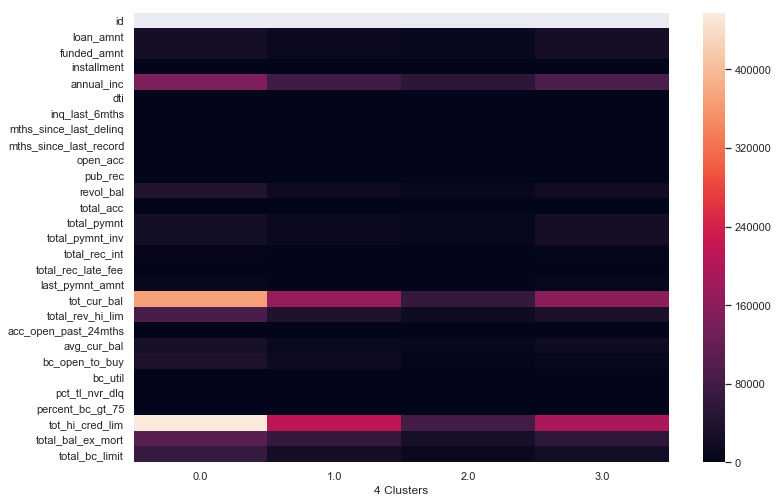

In [26]:
list_clustering_4 = ['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title',
 'emp_length', 'home_ownership', 'annual_inc', 'issue_d', 'loan_status', 'zip_code', 'addr_state', 'dti',
 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
 'revol_util', 'total_acc', 'initial_list_status', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int',
 'total_rec_late_fee', 'last_pymnt_amnt', 'application_type', 'tot_cur_bal', 'total_rev_hi_lim',
 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', '4 Clusters']

cluster_Table_4 = data_2[list_clustering_4].groupby(['4 Clusters']).mean().round(2)
cluster_Table_4 = cluster_Table_4.T

sns.heatmap(cluster_Table_4)

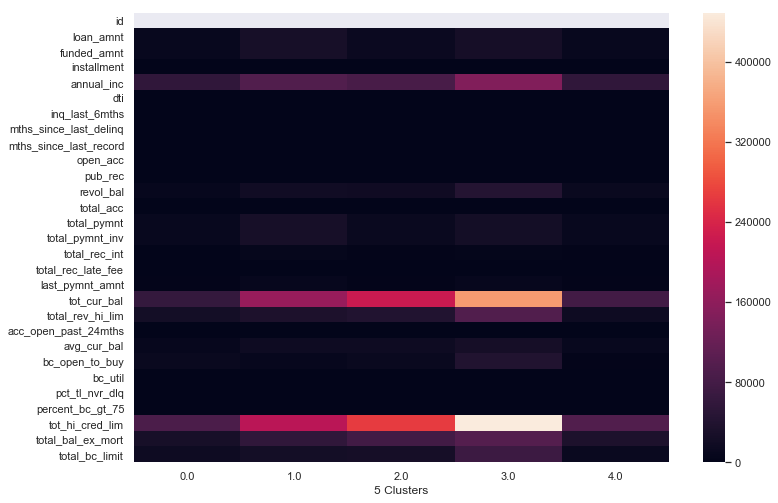

In [27]:
list_clustering_5 = ['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title',
 'emp_length', 'home_ownership', 'annual_inc', 'issue_d', 'loan_status', 'zip_code', 'addr_state', 'dti',
 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
 'revol_util', 'total_acc', 'initial_list_status', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int',
 'total_rec_late_fee', 'last_pymnt_amnt', 'application_type', 'tot_cur_bal', 'total_rev_hi_lim',
 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', '5 Clusters']

cluster_Table_5 = data_2[list_clustering_5].groupby(['5 Clusters']).mean().round(2)
cluster_Table_5 = cluster_Table_5.T

sns.heatmap(cluster_Table_5)

6 Clusters,0.0,1.0,2.0,3.0,4.0,5.0
id,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,15821.94,10516.40,25719.97,26997.63,9049.38,13075.50
funded_amnt,15821.94,10516.40,25719.97,26997.63,9049.38,13075.50
installment,457.43,326.19,734.12,787.34,279.47,388.91
annual_inc,111409.39,55923.04,143612.54,94387.01,56237.73,73525.43
dti,15.99,19.88,19.32,19.51,14.99,22.74
inq_last_6mths,0.55,0.46,0.64,0.54,0.59,0.93
mths_since_last_delinq,30.83,35.18,32.29,33.38,34.44,34.77
mths_since_last_record,68.27,74.15,61.25,69.85,68.04,69.60
open_acc,10.79,9.43,17.71,12.01,9.05,17.73


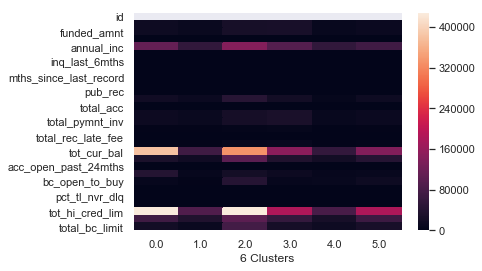

In [19]:
list_clustering_6 = ['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title',
 'emp_length', 'home_ownership', 'annual_inc', 'issue_d', 'loan_status', 'zip_code', 'addr_state', 'dti',
 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
 'revol_util', 'total_acc', 'initial_list_status', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int',
 'total_rec_late_fee', 'last_pymnt_amnt', 'application_type', 'tot_cur_bal', 'total_rev_hi_lim',
 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', '6 Clusters']

cluster_Table_6 = data_2[list_clustering_6].groupby(['6 Clusters']).mean().round(2)
cluster_Table_6 = cluster_Table_6.T

sns.heatmap(cluster_Table_6)
cluster_Table_6

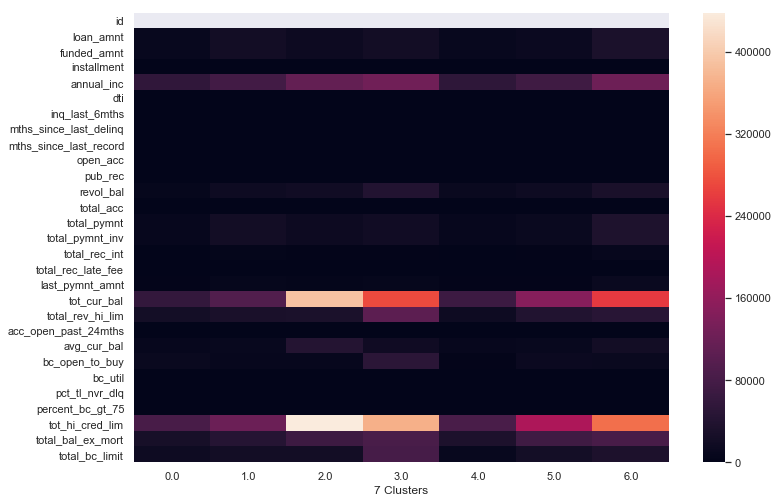

In [29]:
list_clustering_7 = ['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title',
 'emp_length', 'home_ownership', 'annual_inc', 'issue_d', 'loan_status', 'zip_code', 'addr_state', 'dti',
 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
 'revol_util', 'total_acc', 'initial_list_status', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int',
 'total_rec_late_fee', 'last_pymnt_amnt', 'application_type', 'tot_cur_bal', 'total_rev_hi_lim',
 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', '7 Clusters']

cluster_Table_7 = data_2[list_clustering_7].groupby(['7 Clusters']).mean().round(2)
cluster_Table_7 = cluster_Table_7.T

sns.heatmap(cluster_Table_7)

## Using 6 Clusters

Countplots of the categorical data

C:\Users\blitz\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


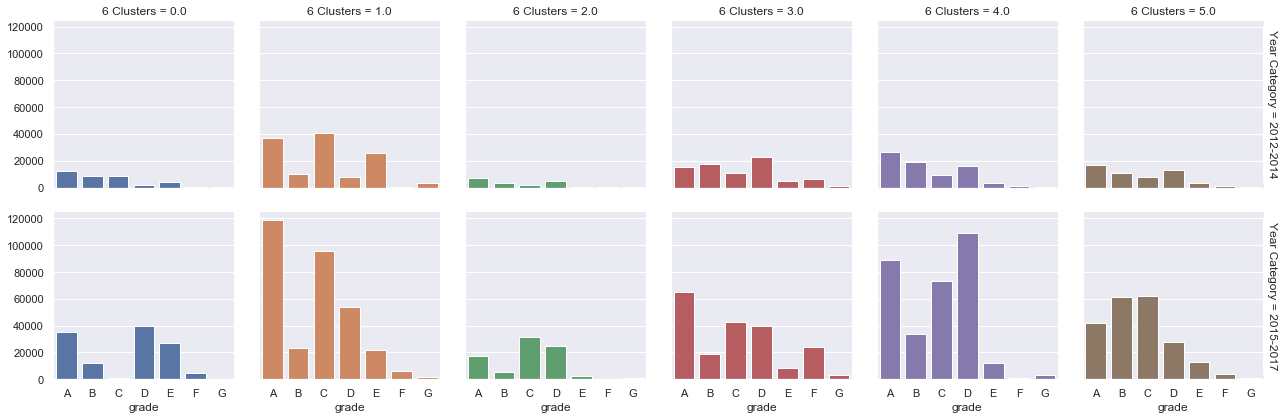

In [44]:
# Create countplots comparing variables across different variables
x = sns.FacetGrid(data_2, row='Year Category', col = "6 Clusters", 
                  margin_titles=True, hue = "6 Clusters")
x.map(sns.countplot, 'grade')

x.savefig("GradebyClusterbyYear.png")

C:\Users\blitz\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


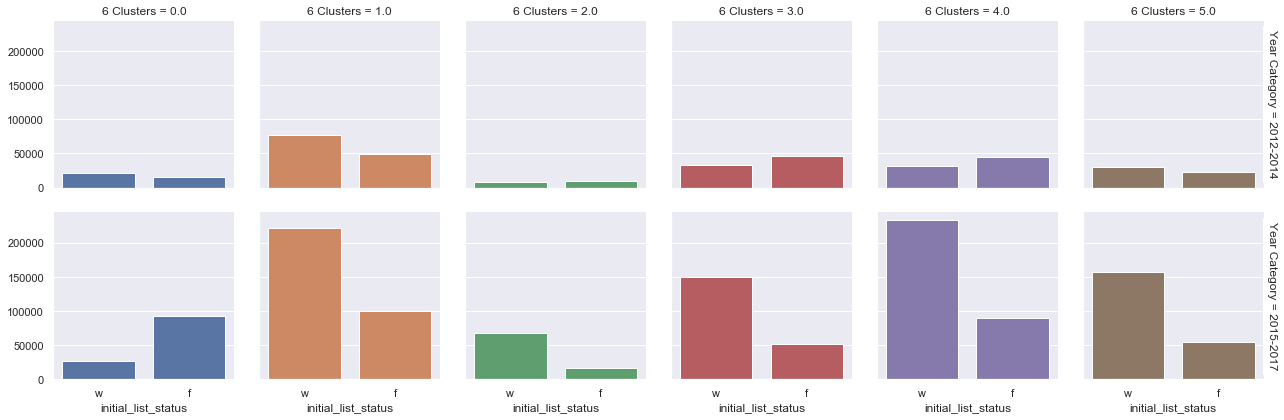

In [45]:
# Create grphs comparing variables across different variables
x = sns.FacetGrid(data_2, row='Year Category', col = "6 Clusters", 
                  margin_titles=True, hue = "6 Clusters")
x.map(sns.countplot, 'initial_list_status')

x.savefig("ListStatusbyClusterbyYear.png")

C:\Users\blitz\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


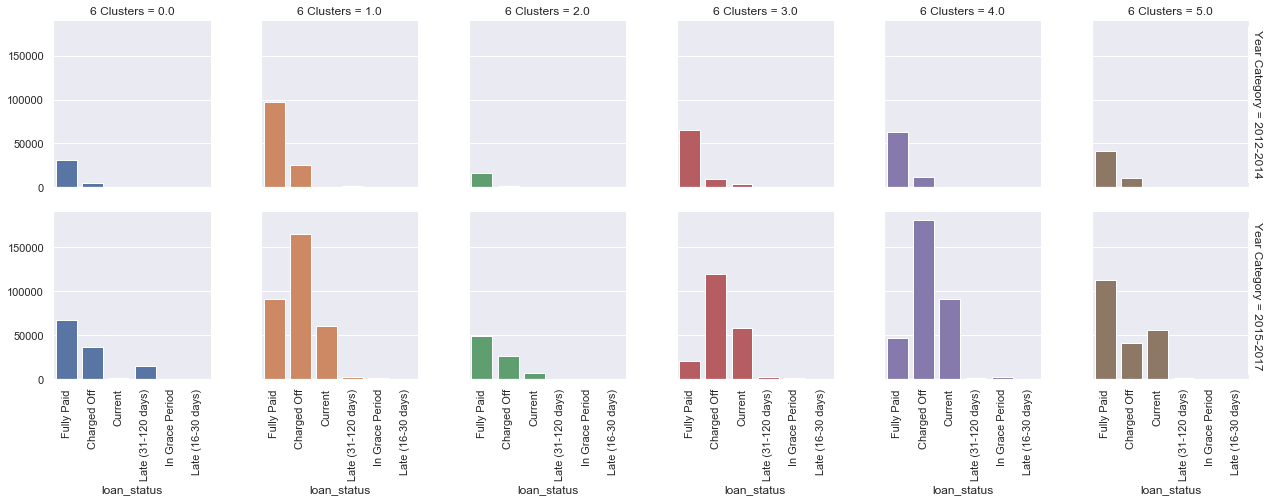

In [46]:
# Create grphs comparing variables across different variables
x = sns.FacetGrid(data_2, row='Year Category', col = "6 Clusters", 
                  margin_titles=True, hue = "6 Clusters")
x.map(sns.countplot, 'loan_status')

# for each x axis, rotate the x-axis labels
for ax in x.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        
x.savefig("LoanStatusbyClusterbyYear.png")

Tables of means for numeric variables

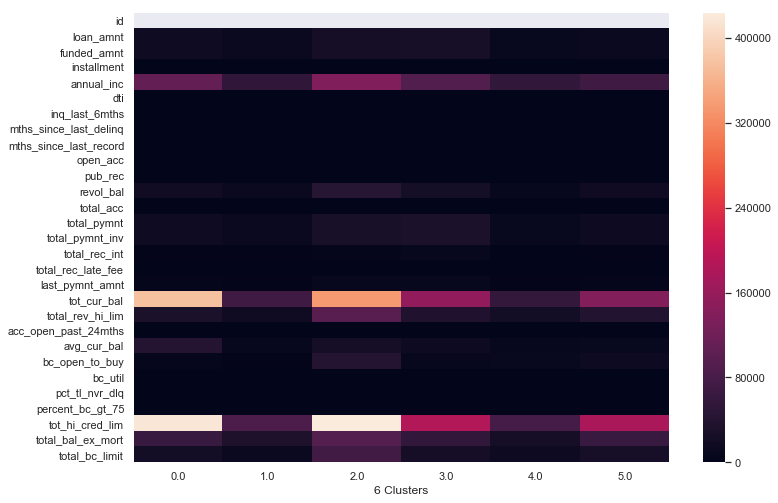

In [47]:
cluster_Table_6_1 = data_1214[list_clustering_6].groupby(['6 Clusters']).mean().round(2)
cluster_Table_6_1 = cluster_Table_6_1.T

sns.heatmap(cluster_Table_6_1)
cluster_Table_6_1.to_csv("6clusters-12-14.csv")

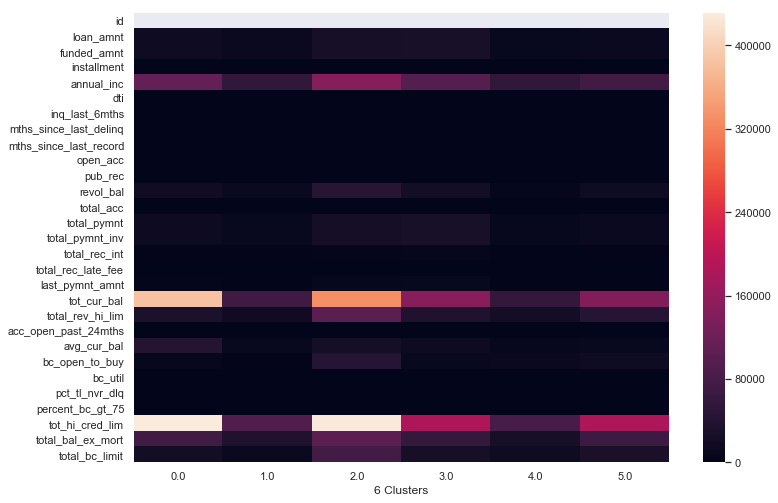

In [48]:
cluster_Table_6_2 = data_1517[list_clustering_6].groupby(['6 Clusters']).mean().round(2)
cluster_Table_6_2 = cluster_Table_6_2.T

sns.heatmap(cluster_Table_6_2)
cluster_Table_6_2.to_csv("6clusters-15-17.csv")

Boxplots of numerical data

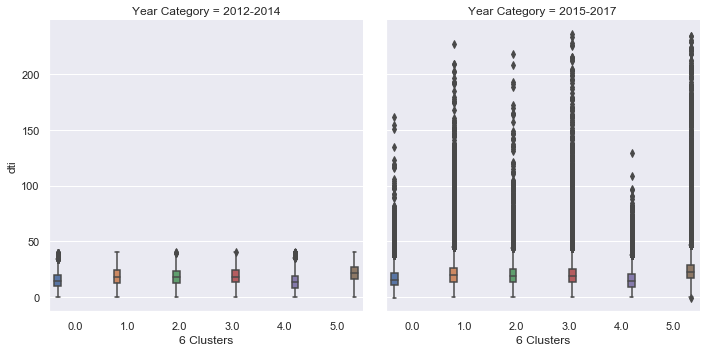

In [13]:
# Create boxplots using catplot comparing variables across different variables
g = sns.catplot(x="6 Clusters", y="dti", 
                hue="6 Clusters", col="Year Category",
                data=data_2, kind="box")

g.savefig("dtibyClusterbyYear.png")

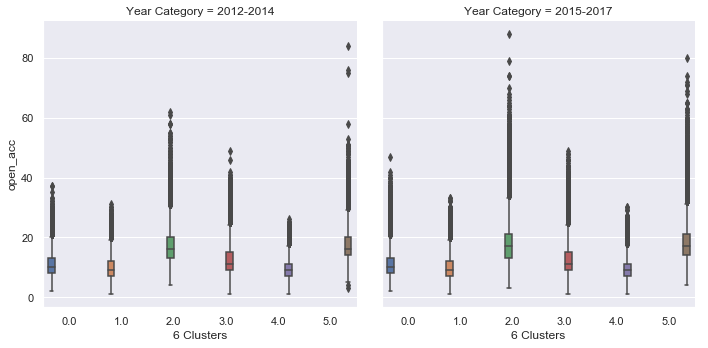

In [55]:
# Create boxplots using catplot comparing variables across different variables
g = sns.catplot(x="6 Clusters", y="open_acc", 
                hue="6 Clusters", col="Year Category",
                data=data_2, kind="box")

# g.savefig("open_accbyClusterbyYear.png")

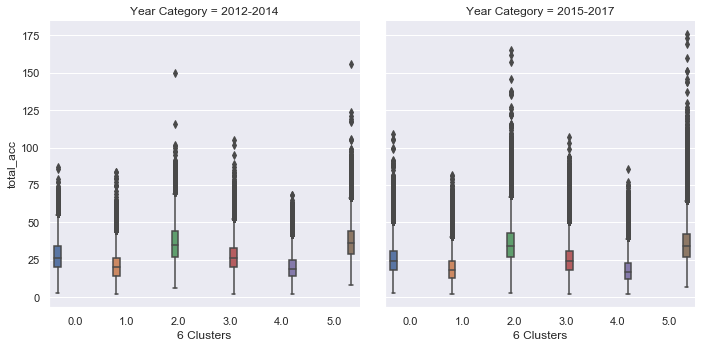

In [56]:
# Create boxplots using catplot comparing variables across different variables
g = sns.catplot(x="6 Clusters", y="total_acc", 
                hue="6 Clusters", col="Year Category",
                data=data_2, kind="box")

# g.savefig("total_accbyClusterbyYear.png")

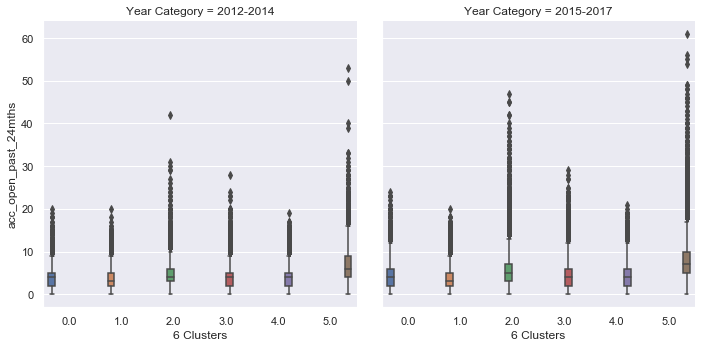

In [57]:
# Create boxplots using catplot comparing variables across different variables
g = sns.catplot(x="6 Clusters", y="acc_open_past_24mths", 
                hue="6 Clusters", col="Year Category",
                data=data_2, kind="box")

# g.savefig("acc_open_past_24mthsbyClusterbyYear.png")

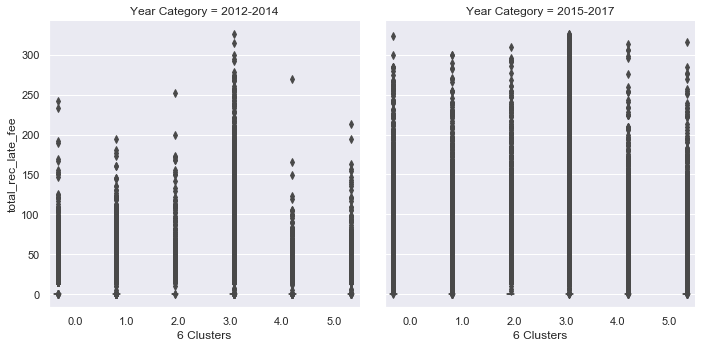

In [58]:
# Create boxplots using catplot comparing variables across different variables
g = sns.catplot(x="6 Clusters", y="total_rec_late_fee", 
                hue="6 Clusters", col="Year Category",
                data=data_2, kind="box")

# g.savefig("total_rec_late_feebyClusterbyYear.png")

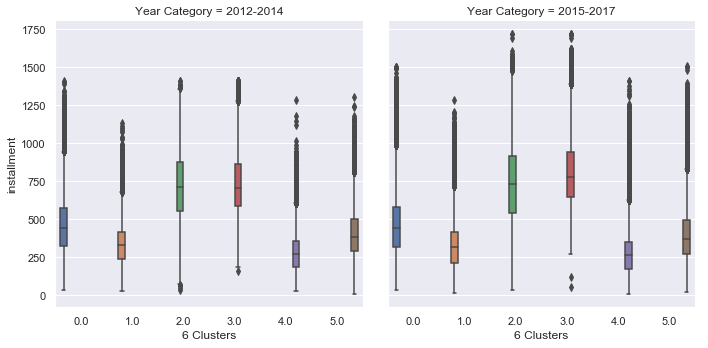

In [59]:
# Create boxplots using catplot comparing variables across different variables
g = sns.catplot(x="6 Clusters", y="installment", 
                hue="6 Clusters", col="Year Category",
                data=data_2, kind="box")

# g.savefig("installmentbyClusterbyYear.png")

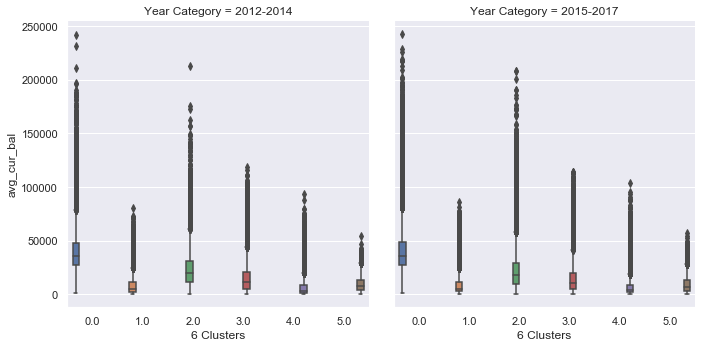

In [60]:
# Create boxplots using catplot comparing variables across different variables
g = sns.catplot(x="6 Clusters", y="avg_cur_bal", 
                hue="6 Clusters", col="Year Category",
                data=data_2, kind="box")

# g.savefig("avg_cur_balbyClusterbyYear.png")

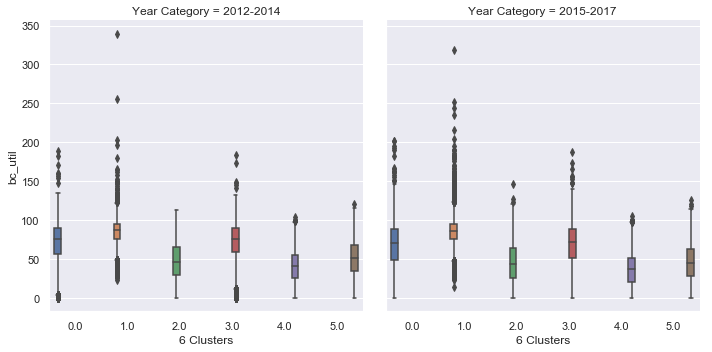

In [7]:
# Create boxplots using catplot comparing variables across different variables
g = sns.catplot(x="6 Clusters", y="bc_util", 
                hue="6 Clusters", col="Year Category",
                data=data_2, kind="box")

g.savefig("bc_utilbyClusterbyYear.png")

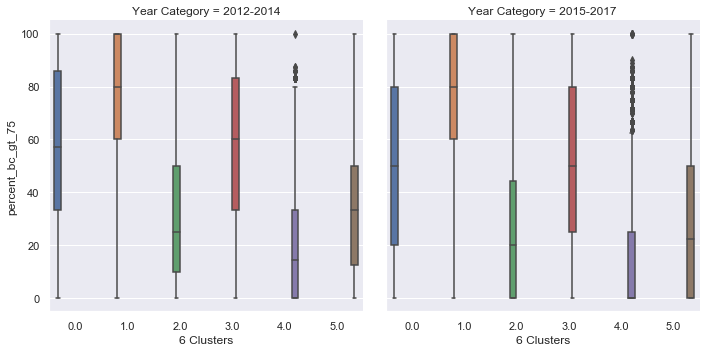

In [8]:
# Create boxplots using catplot comparing variables across different variables
g = sns.catplot(x="6 Clusters", y="percent_bc_gt_75", 
                hue="6 Clusters", col="Year Category",
                data=data_2, kind="box")

g.savefig("percent_bc_gt_75ClusterbyYear.png")